In [1]:
import pandas as pd
import sklearn as sk
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pickle

In [2]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression, Lasso, Ridge

from sklearn.metrics import mean_squared_error

In [3]:
import mlflow

mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("nyc-taxi")

<Experiment: artifact_location='/workspaces/mlops-zoomcamp/02-experiment-tracking/mlruns/1', creation_time=1742206256785, experiment_id='1', last_update_time=1742206256785, lifecycle_stage='active', name='nyc-taxi', tags={}>

# Load data

In [4]:
def read_dataframe(filename):
    df = pd.read_parquet(filename)

    # Calculate trip duration in minutes
    df["duration"] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)
    
    # Filter on trips between 1 and 60 minutes
    df = df[((df.duration >=1) & (df.duration <= 60))]
    
    # Select categorical and numerical variables
    categorical = ['PULocationID', 'DOLocationID']
    numerical = ['trip_distance']

    # Add combinations of pickup and dropoff locations
    df["PU_DO"] = df['PULocationID'].astype(str) + '_' + df['DOLocationID'].astype(str)
    
    # Convert the catergoricals to strings (they are integers originally).
    df.loc[:, categorical] = df[categorical].astype(str)
    
    return df

In [5]:
train_path = './data/green_tripdata_2021-01.parquet'
val_path = './data/green_tripdata_2021-02.parquet'
df_train = read_dataframe(train_path)
df_val = read_dataframe(val_path)

len(df_train), len(df_val)

/tmp/ipykernel_35787/1659746559.py:19: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['43' '166' '41' ... '74' '168' '119']' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[:, categorical] = df[categorical].astype(str)
/tmp/ipykernel_35787/1659746559.py:19: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['151' '239' '42' ... '69' '215' '244']' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[:, categorical] = df[categorical].astype(str)
/tmp/ipykernel_35787/1659746559.py:19: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['130' '152' '152' ... '74' '42' '42']' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[:, categorical] = df[categor

(73908, 61921)

In [6]:
# Filter on trip_type == Dispatch
# df[df.trip_type == 2]

In [7]:
# Select categorical and numerical variables
categorical = ['PULocationID', 'DOLocationID', 'PU_DO']
numerical = ['trip_distance']



dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
val_dicts = df_val[categorical + numerical].to_dict(orient='records')

# Vectorize
X_train = dv.fit_transform(train_dicts)
X_val = dv.transform(val_dicts)

# Set target variable
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

# Train linear regression
lr = LinearRegression()
lr.fit(X_train, y_train)

# Predict on the train set
y_pred_train = lr.predict(X_train)

# Predict on the val set
y_pred_val = lr.predict(X_val)

# Calculate error
mse_train = mean_squared_error(y_train, y_pred_train)
mse_val = mean_squared_error(y_val, y_pred_val)

print(f"mse_train: {mse_train}")
print(f"mse_val: {mse_val}")

print(f"root_mse_train: {np.sqrt(mse_train)}")
print(f"root_mse_val: {np.sqrt(mse_val)}")

with open('./models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

mse_train: 34.796383463695996
mse_val: 59.666722978173155
root_mse_train: 5.89884594337706
root_mse_val: 7.724423795868088


In [8]:
with mlflow.start_run():

    mlflow.set_tag("developer", "jeroen")
    
    mlflow.log_param("train-data-path", train_path)
    mlflow.log_param("val-data-path", val_path)
    
    alpha = 0.01

    mlflow.log_param("alpha", alpha)
    
    # Try Lasso model
    lr = Lasso(alpha)
    lr.fit(X_train, y_train)
    
    y_pred_val = lr.predict(X_val)
    
    # Calculate error
    mse_train = mean_squared_error(y_train, y_pred_train)
    mse_val = mean_squared_error(y_val, y_pred_val)

    rmse_val = np.sqrt(mse_val)
    print(f"root_mse_train: {np.sqrt(mse_train)}")
    print(f"root_mse_val: {rmse_val}")
    
    mlflow.log_metric("rmse", rmse_val)

root_mse_train: 5.89884594337706
root_mse_val: 10.606140572165677


In [9]:
# Try Ridge model
lr = Ridge()
lr.fit(X_train, y_train)

y_pred_val = lr.predict(X_val)

# Calculate error
mse_train = mean_squared_error(y_train, y_pred_train)
mse_val = mean_squared_error(y_val, y_pred_val)

print(f"root_mse_train: {np.sqrt(mse_train)}")
print(f"root_mse_val: {np.sqrt(mse_val)}")

root_mse_train: 5.89884594337706
root_mse_val: 7.484704893625263


In [10]:
X_train

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 295632 stored elements and shape (73908, 13727)>

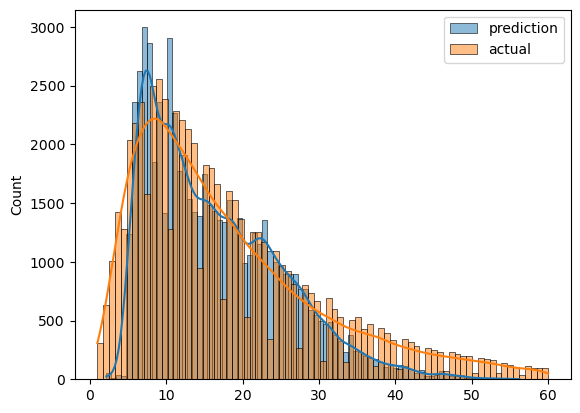

In [11]:
# Visualise the results
sns.histplot(y_pred_val, label='prediction', kde=True, alpha=0.5)
sns.histplot(y_val, label='actual', kde=True, alpha=0.5)
plt.legend()

In [12]:
import xgboost as xgb

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

In [13]:
# xgboost requires specific xgb.DMatrix format)
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

In [14]:


def objective(params):
    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=100,
            evals=[(valid, 'validation')],
            early_stopping_rounds=10
        )
        y_pred = booster.predict(valid)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        mlflow.log_metric("rmse", rmse)

    return {'loss': rmse, 'status': STATUS_OK}



In [ ]:


search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)), # hp.quniform samples from the defined range (4, 100)
    'learning_rate': hp.loguniform('learning_rate', -3, 0), # Loguniform takes the exponent of the interval: interval is exp(-3), exp(0) [0.05, 1]
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:squarederror',
    'seed': 42
}

best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials()
)


[0]	validation-rmse:10.34597                                                                                                  
[1]	validation-rmse:9.03369                                                                                                   
[2]	validation-rmse:8.13277                                                                                                   
[3]	validation-rmse:7.51943                                                                                                   
[4]	validation-rmse:7.11179                                                                                                   
[5]	validation-rmse:6.84293                                                                                                   
[6]	validation-rmse:6.65969                                                                                                   
[7]	validation-rmse:6.53687                                                                                    